In [1]:
import scanpy as sc
import plotnine as p9

import liana as li
import decoupler as dc # needed for pathway analysis

import warnings

import numpy as np
import pandas as pd

TODO:
- Handle metadata by providing additional columns
- Functions to extract MOFA values assigned to `obsm` & `varm` (so that we don't save the model), and plot them
- wrap up the two functions

## Preprocess

In [2]:
# load data as from CCC chapter
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)

# Store the counts for later use
adata.layers["counts"] = adata.X.copy()

# Rename label to condition, replicate to patient
adata.obs = adata.obs.rename({"label": "condition", "replicate": "patient"}, axis=1)
# assign sample
adata.obs["sample"] = (
    adata.obs["condition"].astype("str") + "&" + adata.obs["patient"].str.slice(8, 13)
)

In [3]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_type'

## MOFAcell

Discard pseudobulk profiles generated with less than 25 cells were discarded. 
Genes detected in less than 25% of the samples were discarded
(Ricardo also filters "Genes with less than a minimum of 100 counts in a single sample")

Generate pseudobulks

In [4]:
views = adata.obs[groupby].unique()
padatas = {}
for celltype in views:
    
    temp = adata[adata.obs[groupby] == celltype]
    
    padata = dc.get_pseudobulk(temp,
                               sample_col=sample_key,
                               groups_col=None, 
                               layer='counts',
                               min_prop=0.05, # min nnz values (feature)
                               min_smpls=2, # min samples per view (feature)
                               min_cells=25, # min cells per view (sample) ! Need this per sample
                               min_counts=-np.inf,
                               mode='sum'
                               )
    # padata.var_names = padata.var_names + '^' + celltype # should check if the sep is in the cell type?
    
    # only append views that pass QC
    if 0 not in padata.shape:
        del padata.obs
        padatas[celltype] = padata
    

In [5]:
padatas

{'CD14+ Monocytes': AnnData object with n_obs × n_vars = 16 × 3478,
 'CD4 T cells': AnnData object with n_obs × n_vars = 16 × 2839,
 'Dendritic cells': AnnData object with n_obs × n_vars = 10 × 5328,
 'NK cells': AnnData object with n_obs × n_vars = 14 × 3054,
 'CD8 T cells': AnnData object with n_obs × n_vars = 11 × 2891,
 'B cells': AnnData object with n_obs × n_vars = 16 × 3407,
 'FCGR3A+ Monocytes': AnnData object with n_obs × n_vars = 11 × 4186}

Convert to mudata

In [6]:
from mudata import MuData

In [7]:
mdata = MuData(padatas)

/home/dbdimitrov/anaconda3/envs/liana-py/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


Add metadata

In [8]:
metadata = adata.obs[[sample_key, condition_key]].drop_duplicates() ## condition_key to **list(columns)

In [9]:
mdata.obs = mdata.obs.reset_index(names=sample_key).merge(metadata).set_index(sample_key)

In [10]:
# This stays out of the function that converts from adata to mdata (highlighted in the Tutorial)
for view in mdata.mod.keys():
    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.highly_variable_genes(mdata.mod[view], flavor='cell_ranger')

Run MOFA

In [11]:
mdata.obs

,condition
sample,
ctrl&101,ctrl
ctrl&1015,ctrl
ctrl&1016,ctrl
ctrl&1039,ctrl
ctrl&107,ctrl
ctrl&1244,ctrl
ctrl&1256,ctrl
ctrl&1488,ctrl
stim&101,stim


In [12]:
import muon as mu
import mofax as mofa

In [13]:
mu.tl.mofa(mdata, 
           use_obs='union',
           convergence_mode='medium',
           verbose=True,
           n_factors=10
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CD14+ Monocytes' group='group1' with N=16 samples and D=3478 features...
Loaded view='CD4 T cells' group='group1' with N=16 samples and D=2839 features...
Loaded view='Dendritic cells' group='group1' with N=16 samples and D=5328 features...
Loaded view='NK cells' group='group1' with N=16 samples and D=3054 features...
Loaded view='CD8 T cells' group='group1' with N=

In [14]:
mdata.obs

,condition
sample,
ctrl&101,ctrl
ctrl&1015,ctrl
ctrl&1016,ctrl
ctrl&1039,ctrl
ctrl&107,ctrl
ctrl&1244,ctrl
ctrl&1256,ctrl
ctrl&1488,ctrl
stim&101,stim


In [15]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

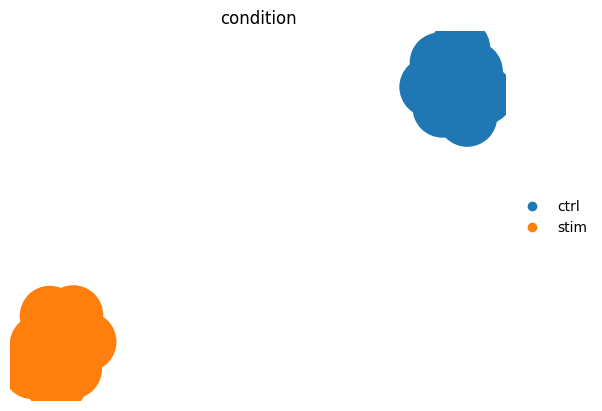

In [16]:
mu.pl.umap(mdata, frameon=False, color='condition')

In [17]:
mdata.varm['LFs'].shape

(25183, 10)

In [18]:
mdata

MuData object with n_obs × n_vars = 16 × 25183
  obs:	'condition'
  obsm:	'X_mofa', 'X_umap'
  varm:	'LFs'
  obsp:	'distances', 'connectivities'
  7 modalities
    CD14+ Monocytes:	16 x 3478
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    CD4 T cells:	16 x 2839
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    Dendritic cells:	10 x 5328
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    NK cells:	14 x 3054
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    CD8 T cells:	11 x 2891
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    B cells:	16 x 3407
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    FCGR3A+ Monocytes:	11 x 4186
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'

### MOFAphone

In [19]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [20]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all information
    n_perms=100, # reduce number of permutations for speed
    return_all_lrs=False, # DON'T return all LR values
    )

Now running: stim&1488: 100%|██████████| 16/16 [01:43<00:00,  6.48s/it]


### dataframe_to_views

adapt: https://github.com/saezlab/liana/blob/dev2/R/liana_mofa.R

In [21]:
# Check if consistent with to_tensor_c2c
# If I'm using any separators, I should remove those symbols from the celltypes
score_key = 'magnitude_rank'
lr_separator = '^'
cell_separator = '&'
lr_prop = 0.5
lr_min = 15
lr_fill = None # or 0?
sample_key = 'sample' ## Change this so that it's always sample (not passed by the user)

^ interaction_min rather than lr as we filter ligand-receptor-source-target interactions (not only ligand-receptor)

Can I avoid using separators, i.e. just group by source, target, etc (not append and then group) + product of all 4

In [22]:
liana_res = adata.uns['liana_res'].copy()

In [23]:
liana_res['interaction'] = liana_res['ligand_complex'] + lr_separator + liana_res['receptor_complex']
liana_res['ct_pair'] = liana_res['source'] + cell_separator + liana_res['target']

In [24]:
liana_res = liana_res[[sample_key, 'ct_pair', 'interaction', score_key]]

In [25]:
liana_res

,sample,ct_pair,interaction,magnitude_rank
0,ctrl&101,FCGR3A+ Monocytes&CD14+ Monocytes,TIMP1^CD63,1.306992e-08
1,ctrl&101,CD14+ Monocytes&CD14+ Monocytes,TIMP1^CD63,4.898851e-07
2,ctrl&101,FCGR3A+ Monocytes&Dendritic cells,TIMP1^CD63,8.347139e-07
3,ctrl&101,NK cells&CD8 T cells,B2M^CD3D,4.464107e-06
4,ctrl&101,CD8 T cells&CD8 T cells,B2M^CD3D,6.749857e-06
...,...,...,...,...
29893,stim&1488,FCGR3A+ Monocytes&NK cells,CLEC2B^KLRF1,1.000000e+00
29894,stim&1488,FCGR3A+ Monocytes&NK cells,TGFB1^CXCR4,1.000000e+00
29895,stim&1488,FCGR3A+ Monocytes&NK cells,GNAI2^CXCR3,1.000000e+00
29896,stim&1488,FCGR3A+ Monocytes&NK cells,SECTM1^CD7,1.000000e+00


Deal with different scores (to be converted to a shared function with tensor_c2c)

In [26]:
from liana.method import get_method_scores
scores = get_method_scores()
inverse_fun = lambda x: 1 - x

In [27]:
if not np.isin(score_key, list(scores.keys())).any():
    raise ValueError(f"Score column {score_key} not found method scores. ")

# reverse if ascending order
ascending_order = scores[score_key]
if(ascending_order):
    liana_res[score_key] = inverse_fun(liana_res[score_key]) #

In [28]:
liana_res

,sample,ct_pair,interaction,magnitude_rank
0,ctrl&101,FCGR3A+ Monocytes&CD14+ Monocytes,TIMP1^CD63,1.000000
1,ctrl&101,CD14+ Monocytes&CD14+ Monocytes,TIMP1^CD63,1.000000
2,ctrl&101,FCGR3A+ Monocytes&Dendritic cells,TIMP1^CD63,0.999999
3,ctrl&101,NK cells&CD8 T cells,B2M^CD3D,0.999996
4,ctrl&101,CD8 T cells&CD8 T cells,B2M^CD3D,0.999993
...,...,...,...,...
29893,stim&1488,FCGR3A+ Monocytes&NK cells,CLEC2B^KLRF1,0.000000
29894,stim&1488,FCGR3A+ Monocytes&NK cells,TGFB1^CXCR4,0.000000
29895,stim&1488,FCGR3A+ Monocytes&NK cells,GNAI2^CXCR3,0.000000
29896,stim&1488,FCGR3A+ Monocytes&NK cells,SECTM1^CD7,0.000000


Generate all possible combinations of interactions and cell types

In [29]:
lrs = liana_res['interaction'].unique()

In [30]:
cell_pairs = liana_res['ct_pair'].unique()

In [31]:
from itertools import product

In [32]:
from mudata import MuData
from anndata import AnnData

In [33]:
import mofax as mofa
import muon as mu

In [34]:
all_combs = list(product(lrs, cell_pairs))
all_combs = pd.DataFrame(all_combs, columns=['interaction', 'ct_pair'])

Check how many combinations are in the data per sample

In [35]:
all_combs

,interaction,ct_pair
0,TIMP1^CD63,FCGR3A+ Monocytes&CD14+ Monocytes
1,TIMP1^CD63,CD14+ Monocytes&CD14+ Monocytes
2,TIMP1^CD63,FCGR3A+ Monocytes&Dendritic cells
3,TIMP1^CD63,NK cells&CD8 T cells
4,TIMP1^CD63,CD8 T cells&CD8 T cells
...,...,...
22283,SEMA4A^PLXNB2,Megakaryocytes&CD4 T cells
22284,SEMA4A^PLXNB2,Megakaryocytes&NK cells
22285,SEMA4A^PLXNB2,Megakaryocytes&CD8 T cells
22286,SEMA4A^PLXNB2,Megakaryocytes&Dendritic cells


In [42]:
# something is wrong here
count_pairs = liana_res.drop(columns=score_key).merge(all_combs, how='right').groupby(['interaction', 'ct_pair']).count().rename(columns={'sample': 'count'}).reset_index()

In [43]:
count_pairs

,interaction,ct_pair,count
0,ACTR2^ADRB2,B cells&B cells,0
1,ACTR2^ADRB2,B cells&CD14+ Monocytes,0
2,ACTR2^ADRB2,B cells&CD4 T cells,0
3,ACTR2^ADRB2,B cells&CD8 T cells,0
4,ACTR2^ADRB2,B cells&Dendritic cells,0
...,...,...,...
22283,ZG16B^TLR4,NK cells&CD4 T cells,0
22284,ZG16B^TLR4,NK cells&CD8 T cells,0
22285,ZG16B^TLR4,NK cells&Dendritic cells,0
22286,ZG16B^TLR4,NK cells&FCGR3A+ Monocytes,0


In [44]:
count_pairs.sort_values('count')

,interaction,ct_pair,count
0,ACTR2^ADRB2,B cells&B cells,0
14038,IL7^IL2RG_IL7R,FCGR3A+ Monocytes&CD4 T cells,0
14037,IL7^IL2RG_IL7R,FCGR3A+ Monocytes&CD14+ Monocytes,0
14036,IL7^IL2RG_IL7R,FCGR3A+ Monocytes&B cells,0
14035,IL7^IL2RG_IL7R,Dendritic cells&NK cells,0
...,...,...,...
20395,TIMP1^CD63,CD14+ Monocytes&Dendritic cells,16
16961,PKM^CD44,NK cells&B cells,16
8800,HLA-A^APLP2,CD14+ Monocytes&CD14+ Monocytes,16
8796,HLA-A^APLP2,B cells&Dendritic cells,16


In [45]:
count_pairs.groupby(['interaction']).size().reset_index(name='counts')

,interaction,counts
0,ACTR2^ADRB2,56
1,ACTR2^LDLR,56
2,ADAM10^AXL,56
3,ADAM10^CD44,56
4,ADAM10^GPNMB,56
...,...,...
393,VEGFA^SIRPA,56
394,VIM^CD44,56
395,ZG16B^CXCR4,56
396,ZG16B^TLR2,56


In [46]:
# I only filter according to interactions across samples, but not cell types

In [47]:
liana_res.groupby(['interaction', sample_key]).size().reset_index(name='counts')

,interaction,sample,counts
0,ACTR2^ADRB2,stim&107,4
1,ACTR2^LDLR,ctrl&1039,6
2,ACTR2^LDLR,stim&1039,6
3,ADAM10^AXL,ctrl&1039,2
4,ADAM10^AXL,stim&1016,2
...,...,...,...
2863,ZG16B^CXCR4,ctrl&107,7
2864,ZG16B^CXCR4,stim&1039,7
2865,ZG16B^TLR2,ctrl&107,2
2866,ZG16B^TLR2,stim&1039,2


Keep only combinations that are above in above a certain proportion of samples

In [51]:
sample_n = liana_res[sample_key].nunique()

In [52]:
count_pairs = count_pairs[count_pairs['count'] >= sample_n * lr_prop]

In [53]:
count_pairs.groupby(['interaction']).size().reset_index(name='counts')

,interaction,counts
0,ADAM10^CD44,7
1,ADM^CALCRL,3
2,ADM^GPR84,1
3,ADM^RAMP1,3
4,ALCAM^CD6,2
...,...,...
146,VCAN^CD44,7
147,VCAN^ITGB1,1
148,VCAN^SELL,1
149,VCAN^TLR2,1


In [54]:
# remove samples views with low sample numbers
liana_res = liana_res.merge(count_pairs.drop(columns='count') , how='inner')

Pivot wider, then anndata

In [57]:
def _dataframe_to_anndata(df):
    obs = pd.DataFrame(index=df.columns)
    var = pd.DataFrame(index=df.index)
    X = np.array(df.values).T
    
    return AnnData(X=X, obs=obs, var=var)

In [58]:
lr_adatas = {}

In [59]:
for ct_pair in liana_res['ct_pair'].unique(): ## add progress bar
    lrs_per_ct = liana_res[liana_res['ct_pair']==ct_pair]
    lrs_wide = lrs_per_ct.pivot(index='interaction',           
                                columns=sample_key,
                                values=score_key)
    lrs_wide.index = lrs_wide.index + '$' + ct_pair
    
    if lrs_wide.shape[0] >= lr_min:
        temp = _dataframe_to_anndata(lrs_wide)
        lr_adatas[ct_pair] = temp
    

Then Mudata

In [60]:
mdata = MuData(lr_adatas)

In [61]:
mu.tl.mofa(mdata, 
           use_obs='union',
           convergence_mode='medium',
           n_factors=10)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='FCGR3A+ Monocytes&CD14+ Monocytes' group='group1' with N=16 samples and D=60 features...
Loaded view='CD14+ Monocytes&CD14+ Monocytes' group='group1' with N=16 samples and D=71 features...
Loaded view='FCGR3A+ Monocytes&Dendritic cells' group='group1' with N=16 samples and D=57 features...
Loaded view='NK cells&CD8 T cells' group='group1' with N=16 samples and D=31 

In [62]:
mdata.obs

""
sample
ctrl&101
ctrl&1015
ctrl&1016
ctrl&1039
ctrl&107
ctrl&1244
ctrl&1256
ctrl&1488
stim&101


Extract MOFA values

In [63]:
sc.get.obs_df(mdata, obsm_keys=[('X_mofa', 0)])

,X_mofa-0
sample,
ctrl&101,0.306882
ctrl&1015,0.273026
ctrl&1016,0.296918
ctrl&1039,0.065341
ctrl&107,0.086609
ctrl&1244,0.293755
ctrl&1256,-0.033916
ctrl&1488,0.296518
stim&101,-0.217690


In [ ]:
mdata.varm['LFs'].shape

In [64]:
lrs_fact1 = sc.get.var_df(mdata, varm_keys=[('LFs', 0)]).reset_index()

In [65]:
lrs_fact1['interaction'].str.split('$', 1, expand=True)

,0,1
0,ADAM10^CD44,FCGR3A+ Monocytes&CD14+ Monocytes
1,ANXA1^FPR1,FCGR3A+ Monocytes&CD14+ Monocytes
2,ANXA2^TLR2,FCGR3A+ Monocytes&CD14+ Monocytes
3,ARF6^SMAP1,FCGR3A+ Monocytes&CD14+ Monocytes
4,B2M^LILRB1,FCGR3A+ Monocytes&CD14+ Monocytes
...,...,...
1683,HMGB1^HAVCR2,CD8 T cells&Dendritic cells
1684,LGALS1^PTPRC,CD8 T cells&Dendritic cells
1685,PKM^CD44,CD8 T cells&Dendritic cells
1686,TIMP1^CD63,CD8 T cells&Dendritic cells


In [66]:
lrs_fact1[['interaction', 'cell_pair']] = lrs_fact1['interaction'].str.split('$', 1, expand=True)
lrs_fact1[['ligand_complex', 'receptor_complex']] = lrs_fact1['interaction'].str.split('^', 1, expand=True)
lrs_fact1[['source', 'target']] = lrs_fact1['cell_pair'].str.split('&', 1, expand=True)

In [67]:
lrs_fact1 = lrs_fact1.rename(columns={"LFs-{0}".format(0):'loadings'})

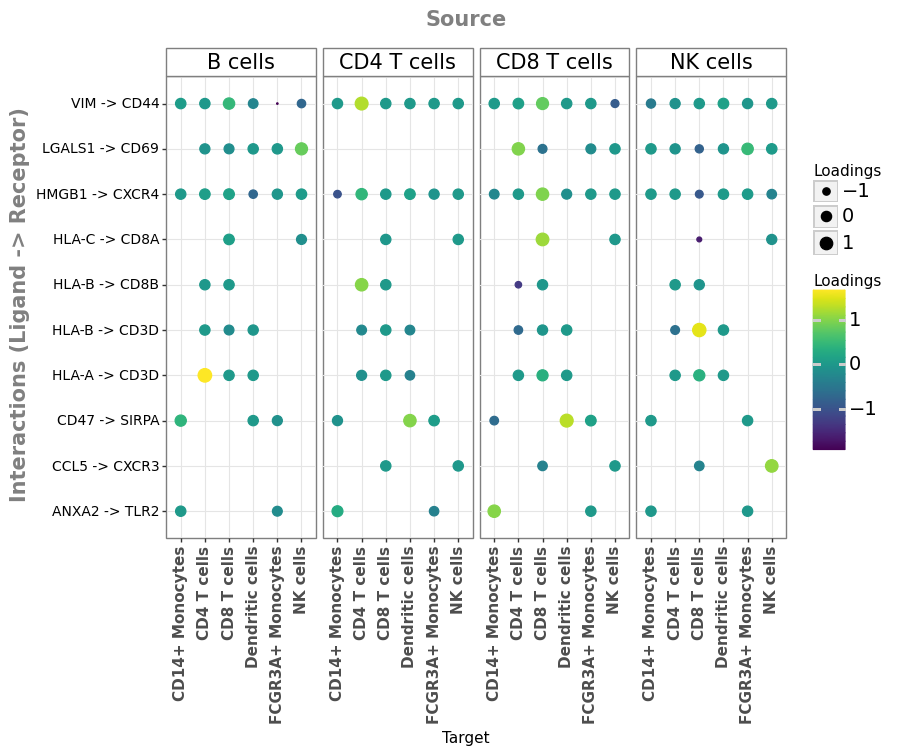

<ggplot: (8755077157516)>

In [68]:
li.pl.dotplot(liana_res = lrs_fact1,
              size='loadings',
              colour='loadings', 
              orderby='loadings',
              top_n=10,
              source_labels=['NK cells', 'B cells', 'CD4 T cells', 'CD8 T cells'],
              orderby_ascending=False,
              size_range=(0.1, 5)
              )

In [69]:
obsm_fact1 = sc.get.obs_df(mdata, obsm_keys=[('X_mofa', 0)]).reset_index()

In [70]:
factor_scores = pd.DataFrame(mdata.obsm['X_mofa'], index=mdata.obs.index)

In [71]:
factor_scores.columns = ['Factor_{0}'.format(x + 1) for x in range(factor_scores.shape[1])]

In [72]:
factor_scores = factor_scores.reset_index()

In [73]:
import plotnine as p9

In [74]:
factor_scores

,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Factor_8,Factor_9,Factor_10
0,ctrl&101,0.306882,-0.012333,-0.001491,0.006195,-0.008737,0.0,0.0,0.0,0.0,0.0
1,ctrl&1015,0.273026,-0.028846,-0.010905,0.006891,-0.008187,0.0,0.0,0.0,0.0,0.0
2,ctrl&1016,0.296918,-0.022471,-0.010478,0.006513,-0.008805,0.0,0.0,0.0,0.0,0.0
3,ctrl&1039,0.065341,0.252791,-0.011253,0.006208,-0.007579,0.0,0.0,0.0,0.0,0.0
4,ctrl&107,0.086609,0.087829,0.103879,0.002969,-0.008530,0.0,0.0,0.0,0.0,0.0
5,ctrl&1244,0.293755,-0.025988,-0.010695,0.004867,-0.008382,0.0,0.0,0.0,0.0,0.0
6,ctrl&1256,-0.033916,-0.024272,-0.010410,0.005734,-0.008731,0.0,0.0,0.0,0.0,0.0
7,ctrl&1488,0.296518,-0.027810,-0.008360,0.004561,-0.008709,0.0,0.0,0.0,0.0,0.0
8,stim&101,-0.217690,-0.031338,-0.010411,0.005174,-0.008044,0.0,0.0,0.0,0.0,0.0
9,stim&1015,-0.186763,-0.029802,-0.011255,0.006814,-0.008367,0.0,0.0,0.0,0.0,0.0


In [75]:
factor_scores['condition'] = factor_scores['sample'].apply(lambda x: x.split('&')[0])

In [76]:
factor_scores

,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Factor_8,Factor_9,Factor_10,condition
0,ctrl&101,0.306882,-0.012333,-0.001491,0.006195,-0.008737,0.0,0.0,0.0,0.0,0.0,ctrl
1,ctrl&1015,0.273026,-0.028846,-0.010905,0.006891,-0.008187,0.0,0.0,0.0,0.0,0.0,ctrl
2,ctrl&1016,0.296918,-0.022471,-0.010478,0.006513,-0.008805,0.0,0.0,0.0,0.0,0.0,ctrl
3,ctrl&1039,0.065341,0.252791,-0.011253,0.006208,-0.007579,0.0,0.0,0.0,0.0,0.0,ctrl
4,ctrl&107,0.086609,0.087829,0.103879,0.002969,-0.008530,0.0,0.0,0.0,0.0,0.0,ctrl
5,ctrl&1244,0.293755,-0.025988,-0.010695,0.004867,-0.008382,0.0,0.0,0.0,0.0,0.0,ctrl
6,ctrl&1256,-0.033916,-0.024272,-0.010410,0.005734,-0.008731,0.0,0.0,0.0,0.0,0.0,ctrl
7,ctrl&1488,0.296518,-0.027810,-0.008360,0.004561,-0.008709,0.0,0.0,0.0,0.0,0.0,ctrl
8,stim&101,-0.217690,-0.031338,-0.010411,0.005174,-0.008044,0.0,0.0,0.0,0.0,0.0,stim
9,stim&1015,-0.186763,-0.029802,-0.011255,0.006814,-0.008367,0.0,0.0,0.0,0.0,0.0,stim


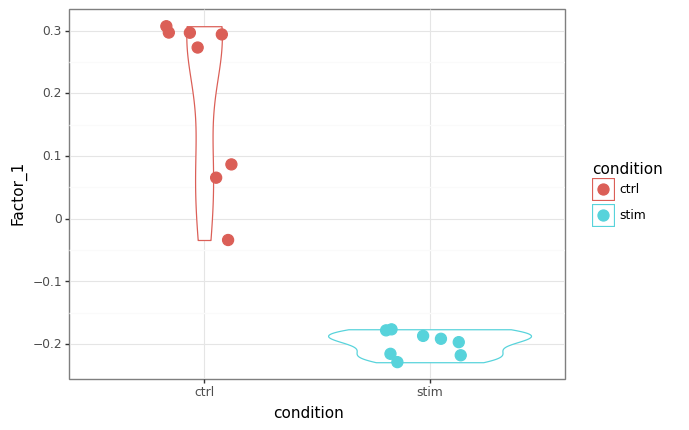

<ggplot: (8755077767931)>

In [77]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw()
 )

In [78]:
factor_scores

,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Factor_8,Factor_9,Factor_10,condition
0,ctrl&101,0.306882,-0.012333,-0.001491,0.006195,-0.008737,0.0,0.0,0.0,0.0,0.0,ctrl
1,ctrl&1015,0.273026,-0.028846,-0.010905,0.006891,-0.008187,0.0,0.0,0.0,0.0,0.0,ctrl
2,ctrl&1016,0.296918,-0.022471,-0.010478,0.006513,-0.008805,0.0,0.0,0.0,0.0,0.0,ctrl
3,ctrl&1039,0.065341,0.252791,-0.011253,0.006208,-0.007579,0.0,0.0,0.0,0.0,0.0,ctrl
4,ctrl&107,0.086609,0.087829,0.103879,0.002969,-0.008530,0.0,0.0,0.0,0.0,0.0,ctrl
5,ctrl&1244,0.293755,-0.025988,-0.010695,0.004867,-0.008382,0.0,0.0,0.0,0.0,0.0,ctrl
6,ctrl&1256,-0.033916,-0.024272,-0.010410,0.005734,-0.008731,0.0,0.0,0.0,0.0,0.0,ctrl
7,ctrl&1488,0.296518,-0.027810,-0.008360,0.004561,-0.008709,0.0,0.0,0.0,0.0,0.0,ctrl
8,stim&101,-0.217690,-0.031338,-0.010411,0.005174,-0.008044,0.0,0.0,0.0,0.0,0.0,stim
9,stim&1015,-0.186763,-0.029802,-0.011255,0.006814,-0.008367,0.0,0.0,0.0,0.0,0.0,stim
